In [1]:
!pip install git+https://github.com/maciejkula/spotlight.git
!pip install git+https://github.com/mangaki/zero
!pip install numpy matplotlib scikit-learn seaborn

  Cloning https://github.com/maciejkula/spotlight.git to /tmp/pip-req-build-8_3ng0ry
  Running command git clone --filter=blob:none --quiet https://github.com/maciejkula/spotlight.git /tmp/pip-req-build-8_3ng0ry
  Resolved https://github.com/maciejkula/spotlight.git to commit 75f4c8c55090771b52b88ef1a00f75bb39f9f2a9
  Preparing metadata (setup.py) ... done
  Created wheel for spotlight: filename=spotlight-0.1.6-py3-none-any.whl size=33895 sha256=0969be3b85ffcc636d65c276056e40e97d67cedc35132aa3f0b14dfaad0a0f73
  Stored in directory: /tmp/pip-ephem-wheel-cache-t3z_iuws/wheels/d1/08/ee/45e61c6a791fdd520a5a95479ec9fc0acbbae916ba0456b358
Successfully built spotlight
  Cloning https://github.com/mangaki/zero to /tmp/pip-req-build-9_3efcl0
  Running command git clone --filter=blob:none --quiet https://github.com/mangaki/zero /tmp/pip-req-build-9_3efcl0
  Resolved https://github.com/mangaki/zero to commit f526bbc538a45bdbe09e82b50c4890e90ea2202b
  Installing build dependencies ... done
  Getti

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2024-12-26 08:49:15--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  21.0MB/s    in 0.2s    

2024-12-26 08:49:15 (21.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
# Option 2: whithout considering the specific user
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances, linear_kernel
from sklearn.linear_model import Ridge
from zero.svd import MangakiSVD

# Load the MovieLens dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=('user', 'item', 'rating', 'timestamp'))
titles = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin1', names=('item', 'title', 'date', 'wat', 'link') + tuple(range(19)))
titles = titles[['item', 'title']]

# Zero-index the user and item columns
ratings['user'] = ratings['user'] - 1
ratings['item'] = ratings['item'] - 1

# Convert to numpy arrays
y = ratings['rating'].to_numpy()  # 1D array of ratings
X = ratings[['user', 'item']].to_numpy()  # 2D array of (user, item)

# Initialize SVD model
np.random.seed(42)
model = MangakiSVD(nb_components=10)

# Set the correct number of users and items
model.nb_users = ratings['user'].max() + 1
model.nb_works = ratings['item'].max() + 1

# User to exclude
user_to_exclude = 0

# Step 1: Mask the user's interactions
mask = X[:, 0] != user_to_exclude
X_masked = X[mask]  # Exclude rows for the specific user
y_masked = y[mask]  # Exclude corresponding ratings

# Step 2: Fit the model without the user's interactions
model.fit(X_masked, y_masked)
user_embedding_excluded = model.U[user_to_exclude, :]

# Step 3: Fit the model on the full dataset
model.fit(X, y)

# Step 4: Replace the user's embedding with the one from step 2
model.U[user_to_exclude, :] = user_embedding_excluded

# Get item embeddings and user embeddings from the trained model
embeddings_I = model.VT.T * model.sigma  # Item embeddings
embeddings_U = model.U  # User embeddings

# Final user embeddings
print("Final User Embeddings (with replaced user embedding):")
print(embeddings_U)


Computing M: (943 × 1682)
Shapes (943, 10) (10,) (10, 1682)
Computing M: (943 × 1682)
Shapes (943, 10) (10,) (10, 1682)
Final User Embeddings (with replaced user embedding):
[[ 0.00000000e+00  1.73472348e-18 -1.08352455e-17 ...  2.16840434e-17
   2.32019265e-17  1.17093835e-17]
 [ 1.85917825e-02  3.35021827e-02  3.88684256e-02 ... -1.89507767e-02
   1.11825221e-02  1.22451143e-02]
 [ 9.35898635e-03 -9.11031576e-03  9.52341280e-03 ...  3.61424214e-03
   3.65908113e-03  4.66969080e-03]
 ...
 [-6.52306789e-03 -9.12694372e-03 -8.68286839e-03 ... -3.79336928e-03
   1.92858933e-03  3.96824165e-03]
 [ 6.87373179e-04 -1.28422564e-02  1.72763948e-03 ... -2.05716152e-02
  -7.30142363e-03  6.83209772e-03]
 [ 6.38726236e-02 -2.07436530e-02 -4.13706190e-04 ...  6.81651794e-02
  -2.75546608e-02  5.42046499e-02]]


In [4]:
# Precompute the linear dissimilarity matrix between items
dissimilarity_matrix = linear_kernel(embeddings_I) #linear kernel

# Precompute all user-item similarities for a given user
def precompute_user_item_similarities(user_id, embeddings_U, embeddings_I):
    user_embedding = embeddings_U[user_id].reshape(1, -1)
    user_item_similarities = linear_kernel(user_embedding, embeddings_I).flatten()  # Similarity between the user and all items
    return user_item_similarities

user_id = 0  # user ID, can be changed based on which user to recommend to

user_item_similarities = precompute_user_item_similarities(user_id, embeddings_U, embeddings_I)


In [5]:
# Get items liked by the user
def get_items_liked_by_user(user_id, ratings, threshold=3):
    # Filter ratings for the specified user and return items with a rating above the threshold
    liked_items = ratings[(ratings['user'] == user_id) & (ratings['rating'] >= threshold)]
    Nliked_items = ratings[(ratings['user'] == user_id) & (ratings['rating'] < threshold)]
    return liked_items['item'].to_numpy(), Nliked_items['item'].to_numpy()
#user_id = 0
liked_items, Nliked_items = get_items_liked_by_user(user_id, ratings)

In [6]:
import random

# Initialize rewards, counts, and feedback log
num_items = model.nb_works
rewards = np.zeros(num_items)
counts = np.zeros(num_items)
feedback_log = []  # To track feedback (True/False)

# Function to compute UCB
def compute_ucb(reward, count, total_count):
    degree_expl = 200  # Degree of exploration
    if count == 0:
        return float('inf')  # Encourage exploration for unselected items
    exploration_bonus = np.sqrt(2 * np.log(total_count) / count)
    return reward + degree_expl * exploration_bonus

# Adaptive Pareto front movie recommendation with UCB
def recommend_movie_pareto_ucb(user_id, dissimilarity_matrix, rewards, counts, selected_movies, div, rel):
    total_count = sum(counts)  # Total feedback count across items
    user_embedding = embeddings_U[user_id]  # Get the user's embedding
    user_item_dissimilarity = linear_kernel(user_embedding.reshape(1, -1), embeddings_I).flatten()  # User-item similarity linear kernel

    pareto_front = []

    for i in range(num_items):
        if i not in selected_movies:
            avg_dissimilarity = np.mean([dissimilarity_matrix[i][m] for m in selected_movies]) if selected_movies else 1.0
            #avg_dissimilarity = ([dissimilarity_matrix[i][m] for m in selected_movies]) if selected_movies else 1.0
            user_similarity = user_item_dissimilarity[i]  # Relevance to the user
            #avg_dissimilarity = np.mean(avg_dissimilarity, 1/user_similarity)  # Relevance to the user

            # Compute UCB for this item
            ucb_score = compute_ucb(rewards[i], counts[i], total_count)

            # Add to Pareto front based on diversity (avg_dissimilarity), user similarity, and UCB
            pareto_front.append((i,  (avg_dissimilarity),  (1/user_similarity), ucb_score)) #+ 1 *(1/user_similarity)
            #pareto_front.append((i, 0.5 * avg_dissimilarity, ucb_score))

    # Sort Pareto front: prioritize user similarity, then diversity, then UCB

    #pareto_front_sorted = sorted(pareto_front, key=lambda x: (x[1], -x[2], -x[3]))  # Maximize user similarity first
    if random.random() < div:
    # Sort by (x[1], -x[2], -x[3])
      pareto_front_sorted = sorted(pareto_front, key=lambda x: (x[1], -x[2], -x[3])) # Maximize items dissimilarities first
    else:
    # Sort by (-x[2], x[1], -x[3])
    #if 0.25 <= random.random() < 0.5:
      if(random.random() < rel):
        pareto_front_sorted = sorted(pareto_front, key=lambda x: (-x[2], x[1], -x[3])) # Maximize user similarity first
      else:
        pareto_front_sorted = sorted(pareto_front, key=lambda x: (-x[3], -x[2], x[1])) # Maximize exploration first

    #pareto_front_sorted = sorted(pareto_front, key=lambda x: (x[1], -x[2]))
    selected_movie = pareto_front_sorted[0][0]  # Choose the top Pareto front item
    return selected_movie


def calculate_ridge_leverage_scores(embeddings_I, embeddings_U, user_id, alpha=1.0):
    # Fit Ridge regression on item embeddings
    model = Ridge(alpha=alpha)
    model.fit(embeddings_I, np.arange(embeddings_I.shape[0]))  # Dummy target for fitting

    # Get the embedding for the specified user
    user_embedding = embeddings_U[user_id]

    # Compute user-item similarity for all items (e.g., using dot product)
    user_similarity = linear_kernel(user_embedding.reshape(1, -1), embeddings_I).flatten()

    # Calculate leverage scores, weighted by user similarity
    leverage_scores = np.array([np.sum(model.coef_ * item) / user_similarity[i] for i, item in enumerate(embeddings_I)])

    return leverage_scores

# Function to calculate the DPP score based on selected movies and user's similarity
def calculate_dpp(selected_movies, dissimilarity_matrix, user_item_similarities):
    if len(selected_movies) == 0:
        return 0.0  # Return 0 if no movies are selected

    # Compute the kernel matrix for selected movies, considering both dissimilarity and precomputed user similarity
    kernel_matrix = np.zeros((len(selected_movies), len(selected_movies)))

    for i in range(len(selected_movies)):
        for j in range(len(selected_movies)):
            # Item-item dissimilarity component (for diversity)
            item_dissimilarity = dissimilarity_matrix[selected_movies[i], selected_movies[j]] #np.exp(-dissimilarity_matrix[selected_movies[i], selected_movies[j]])

            # Precomputed user-item similarity component (for relevance to the user)
            similarity_to_user_i = 1/user_item_similarities[selected_movies[i]]
            similarity_to_user_j = 1/user_item_similarities[selected_movies[j]]

            # Combine item dissimilarity and user similarity into the kernel
            #kernel_matrix[i, j] = item_dissimilarity * np.sqrt(similarity_to_user_i * similarity_to_user_j)
            if similarity_to_user_i < 0 or similarity_to_user_j < 0:
                kernel_matrix[i, j] = 0  # or handle this case differently
            else:
                user_similarity_product = similarity_to_user_i * similarity_to_user_j
                if user_similarity_product < 0:
                    kernel_matrix[i, j] = 0
                else:
                    kernel_matrix[i, j] = item_dissimilarity * np.sqrt(user_similarity_product)


    # Compute the DPP score as the determinant of the kernel matrix
    dpp_score = np.linalg.det(kernel_matrix)
    return dpp_score

# Function to simulate adaptive feedback based on DPP and user's similarity
def get_feedback(selected_movie, user_id, dissimilarity_matrix, selected_movies, user_item_similarities, leverage_scores, metric = 'all'):

    avg_dissimilarity = np.mean([dissimilarity_matrix[selected_movie][m] for m in selected_movies]) if selected_movies else 1.0

    # Calculate the DPP score, incorporating user similarity
    dpp_score = calculate_dpp(selected_movies, dissimilarity_matrix, user_item_similarities)

    avg_leverage_score = np.mean([leverage_scores[m] for m in selected_movies]) if selected_movies else 1.0
    # Ensure feedback is a single scalar value
    leverage_probability = (leverage_scores[selected_movie] / (avg_leverage_score + 1e-6) * 0.5)

    user_embedding = embeddings_U[user_id]
    movie_embedding = embeddings_I[selected_movie]

    # Compute user-item similarity (relevance)
    user_similarity = linear_kernel(user_embedding.reshape(1, -1), movie_embedding.reshape(1, -1)).flatten()[0]


    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-6

    # Calculate the feedback probability as the ratio of diversity to relevance
    feedback_ratio = avg_dissimilarity / (user_similarity - epsilon)

    # Combine the two factors: diversity and relevance to user
    #feedback_probability = 0.5 * dpp_score + 0.5 * (1/user_similarity) + 0.5 * leverage_probability  # Adjust the weight as needed
    #feedback_ratio1 = dpp_score + feedback_ratio + leverage_probability  # Adjust the weight as needed


    # Convert ratio into a probability (you can adjust the scaling factor)
    #feedback_probability = np.clip(0.8 * feedback_ratio1, 0, 1)  # Ensure the value is between 0 and 1  (0.8 * feedback_probability, 0, 1)
    if metric == "all":
      feedback_probability = np.clip(1 * dpp_score + 1 * feedback_ratio + 1 * leverage_probability, 0, 1)  # Adjust weights as needed
    else:
      if metric == "dpp":
        feedback_probability = np.clip(1 * dpp_score + 1 * feedback_ratio + 0 * leverage_probability, 0, 1)  # Adjust weights as needed
      else:
        feedback_probability = np.clip(0 * dpp_score + 1 * feedback_ratio + 1 * leverage_probability, 0, 1)  # Adjust weights as needed

    # Simulate feedback based on DPP score
    #feedback = np.random.random() < (dpp_score * 0.5)  # Adjust the scaling factor if needed
    # Simulate feedback based on the combined probability
    feedback = np.random.random() < feedback_probability
    return feedback


# Function to update rewards and counts based on feedback
def update_rewards(movie, feedback, rewards, counts):
    counts[movie] += 1
    rewards[movie] = ((counts[movie] - 1) * rewards[movie] + feedback) / counts[movie]

# Calculate Ridge leverage scores
#ridge_leverage_scores = calculate_ridge_leverage_scores(embeddings_I)
ridge_leverage_scores = calculate_ridge_leverage_scores(embeddings_I, embeddings_U, user_id, alpha=1.0)




Round 1: Recommended Movie: Wife, The (1995)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 2: Recommended Movie: Substance of Fire, The (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 3: Recommended Movie: Star Wars (1977)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 4: Recommended Movie: Jungle2Jungle (1997)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 5: Recommended Movie: Ill Gotten Gains (1997)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 6: Recommended Movie: Intimate Relations (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 7: Recommended Movie: Entertaining Angels: The 

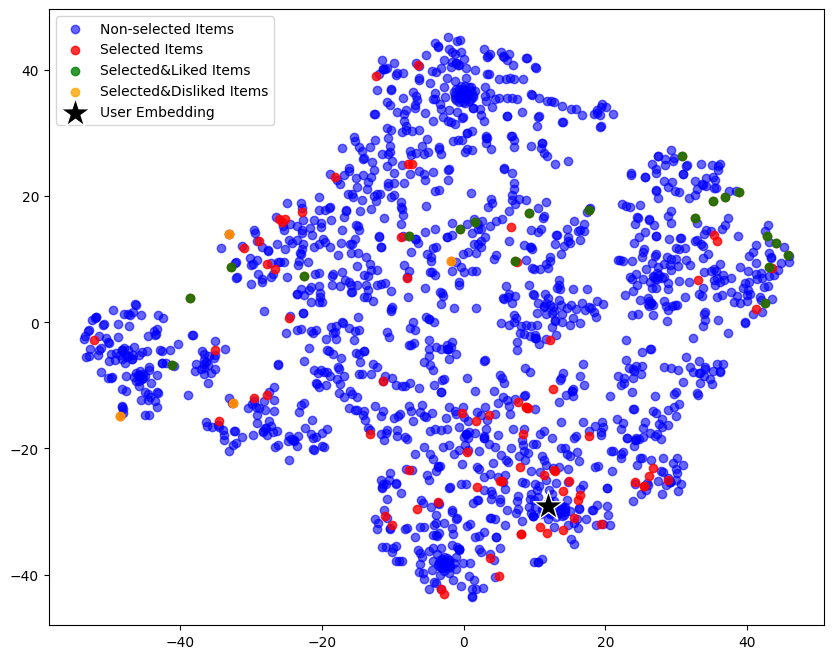

The percentage of liked items is:  20.0
The percentage of disliked items is:  4.0


In [7]:

# Initialize rewards, counts, and feedback log
#num_items = model.nb_works
rewards = np.zeros(num_items)
counts = np.zeros(num_items)
feedback_log = []  # To track feedback (True/False)

# Main recommendation loop
selected_movies = []
rounds = 200  # Number of recommendation rounds
correct_recommendations = 0

div = 0.5
rel = 0.5

for round_num in range(rounds):
    # Recommend a movie
    movie = recommend_movie_pareto_ucb(user_id, dissimilarity_matrix, rewards, counts, selected_movies, div, rel)
    title_value = titles.loc[titles['item'] == (movie + 1), 'title'].values[0]

    print(f"Round {round_num + 1}: Recommended Movie: {title_value}")

    # Get feedback based on the ratio of diversity to user relevance
    feedback = get_feedback(movie, user_id, dissimilarity_matrix, selected_movies, user_item_similarities, ridge_leverage_scores, metric="all")
    feedback_log.append(feedback)  # Log feedback for evaluation
    if feedback:
        correct_recommendations += 1  # Count correct recommendations (positive feedback)

    # Update rewards based on feedback
    update_rewards(movie, feedback, rewards, counts)

    # Add movie to selected list
    selected_movies.append(movie)

    print(f"Feedback for Movie: {feedback}")
    print(f"Updated Rewards: {rewards}")
    print(f"Updated Counts: {counts}\n")

k = 100
# Filter the last k movies selected
selected_movies = selected_movies[-k:]

# Evaluation: Accuracy of the recommendations
accuracy = correct_recommendations / rounds * 100
print(f"Accuracy of Recommendations: {accuracy:.2f}%")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Visualization
# Use t-SNE to reduce dimensions of the item embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
item_embeddings_2d = tsne.fit_transform(embeddings_I)

# Get the user embedding in 2D
user_embedding_2d = tsne.fit_transform(np.vstack([embeddings_I, embeddings_U[user_id]]))[-1]

# Plot the items
plt.figure(figsize=(10, 8))



# Plot non-selected items in blue
non_selected_items = [i for i in range(len(embeddings_I)) if i not in selected_movies]
plt.scatter(item_embeddings_2d[non_selected_items, 0], item_embeddings_2d[non_selected_items, 1], color='blue', label='Non-selected Items', alpha=0.6)

# Plot selected items in red
plt.scatter(item_embeddings_2d[selected_movies, 0], item_embeddings_2d[selected_movies, 1], color='red', label='Selected Items', alpha=0.8)

# Plot selected and liked items, at the same time, in green
liked_selected_items = (set(selected_movies).intersection(set(liked_items)))
Nliked_selected_items = (set(selected_movies).intersection(set(Nliked_items)))
# Convert to NumPy array
liked_selected_items = np.array(list(liked_selected_items))
Nliked_selected_items = np.array(list(Nliked_selected_items))

plt.scatter(item_embeddings_2d[liked_selected_items, 0], item_embeddings_2d[liked_selected_items, 1], color='green', label='Selected&Liked Items', alpha=0.8)
plt.scatter(item_embeddings_2d[Nliked_selected_items, 0], item_embeddings_2d[Nliked_selected_items, 1], color='orange', label='Selected&Disliked Items', alpha=0.8)

# Plot user embedding in bold black
plt.scatter(user_embedding_2d[0], user_embedding_2d[1], color='black', label='User Embedding', s=500, marker='*', edgecolors='white')


# Add labels and legend
#plt.title('t-SNE Visualization of User and Movie Embeddings')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')

# Show plot
plt.show()


percentage_liked = (len(liked_selected_items) / len(selected_movies)) * 100
percentage_Nliked = (len(Nliked_selected_items) / len(selected_movies)) * 100

print("The percentage of liked items is: ", percentage_liked)
print("The percentage of disliked items is: ", percentage_Nliked)

In [ ]:
LAMBDA = 0.01

def compute_leverage_scores(K):
    N = len(K)
    return np.diagonal(K @ np.linalg.inv(K + LAMBDA * np.identity(N)))

In [ ]:
def compute_sim_and_scores(sim):

    last_leverage_scores = compute_leverage_scores(sim)
    print("Leverage scores", last_leverage_scores)
    print("Effective dimension", sum(last_leverage_scores))
    print()

    for i, title in enumerate(content):
        print(f"New item: {title} leverage={compute_leverage_scores(sim[:i + 1, :i + 1])[-1]:.3f}")
        if i > 0:
            print(f"Max similarity to existing profile: {kernel(embeddings[i], embeddings[:i]).max():.3f}")
        print()

In [ ]:
def compute_leverage_scores(X):
    """" Compute the ridge leverage scores """
    lambda_reg = 0.01
    # Compute the hat matrix for ridge regression
    XT = X.T
    I = np.eye(X.shape[1])
    XTX_lambda_I = XT @ X + lambda_reg * I
    XTX_lambda_I_inv = np.linalg.inv(XTX_lambda_I)
    H_ridge = X @ XTX_lambda_I_inv @ XT

    # Extract the diagonal elements of the hat matrix to get the leverage scores
    leverage_scores = np.diag(H_ridge)

    return leverage_scores

In [43]:
def compute_LeverageS1(selected_movies, dissimilarity_matrix, user_item_similarities):#
    # Compute the determinant of the submatrix L_Y
    if len(selected_movies) == 0:
        return 1
    """
    X = L[np.ix_(subset, subset)]

    # compute the new kernel incorporating similarity to he user
    # Compute the kernel matrix for selected movies, considering both dissimilarity and precomputed user similarity
    kernel_matrix = np.zeros((len(subset), len(subset)))

    for i in range(len(subset)):
        for j in range(len(subset)):
            # Item-item dissimilarity component (for diversity)
            item_dissimilarity = X[subset[i], subset[j]] #np.exp(-dissimilarity_matrix[selected_movies[i], selected_movies[j]])

            # Precomputed user-item similarity component (for relevance to the user)
            similarity_to_user_i = 1/user_item_similarities[subset[i]]
            similarity_to_user_j = 1/user_item_similarities[subset[j]]

            # Combine item dissimilarity and user similarity into the kernel
            #kernel_matrix[i, j] = item_dissimilarity * np.sqrt(similarity_to_user_i * similarity_to_user_j)
            if similarity_to_user_i < 0 or similarity_to_user_j < 0:
                kernel_matrix[i, j] = 0  # or handle this case differently
            else:
                user_similarity_product = similarity_to_user_i * similarity_to_user_j
                if user_similarity_product < 0:
                    kernel_matrix[i, j] = 0
                else:
                    kernel_matrix[i, j] = item_dissimilarity * np.sqrt(user_similarity_product)

    """
    if len(selected_movies) == 0:
        return 0.0  # Return 0 if no movies are selected

    # Compute the kernel matrix for selected movies, considering both dissimilarity and precomputed user similarity
    kernel_matrix = np.zeros((len(selected_movies), len(selected_movies)))

    for i in range(len(selected_movies)):
        for j in range(len(selected_movies)):
            print("a")
            # Item-item dissimilarity component (for diversity)
            item_dissimilarity = dissimilarity_matrix[selected_movies[i], selected_movies[j]] #np.exp(-dissimilarity_matrix[selected_movies[i], selected_movies[j]])
            print("b")
            # Precomputed user-item similarity component (for relevance to the user)
            similarity_to_user_i = 1/user_item_similarities[selected_movies[i]]
            similarity_to_user_j = 1/user_item_similarities[selected_movies[j]]
            print("c")
            # Combine item dissimilarity and user similarity into the kernel
            #kernel_matrix[i, j] = item_dissimilarity * np.sqrt(similarity_to_user_i * similarity_to_user_j)
            if similarity_to_user_i < 0 or similarity_to_user_j < 0:
                kernel_matrix[i, j] = 0  # or handle this case differently
            else:
                user_similarity_product = similarity_to_user_i * similarity_to_user_j
                if user_similarity_product < 0:
                    kernel_matrix[i, j] = 0
                else:
                    kernel_matrix[i, j] = item_dissimilarity * np.sqrt(user_similarity_product)

    print("d")
    K = kernel_matrix
    """
    lambda_reg = 0.01
    # Compute the hat matrix for ridge regression
    XT = X.T
    I = np.eye(X.shape[1])
    XTX_lambda_I = XT @ X + lambda_reg * I
    XTX_lambda_I_inv = np.linalg.inv(XTX_lambda_I)
    H_ridge = X @ XTX_lambda_I_inv @ XT

    # Extract the diagonal elements of the hat matrix to get the leverage scores
    leverage_scores = np.diag(H_ridge)
    """
    LAMBDA = 0.01
    N = len(K)
    leverage_scores = np.diagonal(K @ np.linalg.inv(K + LAMBDA * np.identity(N)))
    print("e")
    return leverage_scores[-1]
    #N = len(K)
    #return np.diagonal(K @ np.linalg.inv(K + LAMBDA * np.identity(N)))

In [46]:
def compute_LeverageS(selected_movies, dissimilarity_matrix, user_item_similarities):
    if len(selected_movies) <= 1:
        return 0.0

    kernel_matrix = np.zeros((len(selected_movies), len(selected_movies)))

    for i in range(len(selected_movies)):
        for j in range(len(selected_movies)):
            item_dissimilarity = dissimilarity_matrix[selected_movies[i], selected_movies[j]]
            similarity_to_user_i = 1 / (user_item_similarities[selected_movies[i]] + 1e-6)
            similarity_to_user_j = 1 / (user_item_similarities[selected_movies[j]] + 1e-6)

            if similarity_to_user_i < 0 or similarity_to_user_j < 0:
                kernel_matrix[i, j] = 0
            else:
                kernel_matrix[i, j] = item_dissimilarity * np.sqrt(similarity_to_user_i * similarity_to_user_j)

    K = kernel_matrix
    LAMBDA = 0.01
    N = len(K)

    try:
        leverage_scores = np.diagonal(K @ np.linalg.inv(K + LAMBDA * np.identity(N)))
    except np.linalg.LinAlgError:
        leverage_scores = np.diagonal(K @ np.linalg.pinv(K + LAMBDA * np.identity(N)))

    return leverage_scores[-1]


Modify Reward update

In [47]:
import random

# Initialize rewards, counts, and feedback log
num_items = model.nb_works
rewards = np.zeros(num_items)
counts = np.zeros(num_items)
feedback_log = []  # To track feedback (True/False)

# Function to compute UCB
def compute_ucb(reward, count, total_count):
    degree_expl = 200  # Degree of exploration
    if count == 0:
        return float('inf')  # Encourage exploration for unselected items
    exploration_bonus = np.sqrt(2 * np.log(total_count) / count)
    return reward + degree_expl * exploration_bonus

# Adaptive Pareto front movie recommendation with UCB
def recommend_movie_pareto_ucb(user_id, dissimilarity_matrix, rewards, counts, selected_movies, div, rel):
    total_count = sum(counts)  # Total feedback count across items
    user_embedding = embeddings_U[user_id]  # Get the user's embedding
    user_item_dissimilarity = linear_kernel(user_embedding.reshape(1, -1), embeddings_I).flatten()  # User-item similarity linear kernel

    pareto_front = []

    for i in range(num_items):
        if i not in selected_movies:
            avg_dissimilarity = np.mean([dissimilarity_matrix[i][m] for m in selected_movies]) if selected_movies else 1.0
            #avg_dissimilarity = ([dissimilarity_matrix[i][m] for m in selected_movies]) if selected_movies else 1.0
            user_similarity = user_item_dissimilarity[i]  # Relevance to the user
            #avg_dissimilarity = np.mean(avg_dissimilarity, 1/user_similarity)  # Relevance to the user

            # Compute UCB for this item
            ucb_score = compute_ucb(rewards[i], counts[i], total_count)

            # Add to Pareto front based on diversity (avg_dissimilarity), user similarity, and UCB
            pareto_front.append((i,  (avg_dissimilarity),  (1/user_similarity), ucb_score)) #+ 1 *(1/user_similarity)
            #pareto_front.append((i, 0.5 * avg_dissimilarity, ucb_score))

    # Sort Pareto front: prioritize user similarity, then diversity, then UCB

    #pareto_front_sorted = sorted(pareto_front, key=lambda x: (x[1], -x[2], -x[3]))  # Maximize user similarity first
    if random.random() < div:
    # Sort by (x[1], -x[2], -x[3])
      pareto_front_sorted = sorted(pareto_front, key=lambda x: (x[1], -x[2], -x[3])) # Maximize items dissimilarities first
    else:
    # Sort by (-x[2], x[1], -x[3])
    #if 0.25 <= random.random() < 0.5:
      if(random.random() < rel):
        pareto_front_sorted = sorted(pareto_front, key=lambda x: (-x[2], x[1], -x[3])) # Maximize user similarity first
      else:
        pareto_front_sorted = sorted(pareto_front, key=lambda x: (-x[3], -x[2], x[1])) # Maximize exploration first

    #pareto_front_sorted = sorted(pareto_front, key=lambda x: (x[1], -x[2]))
    selected_movie = pareto_front_sorted[0][0]  # Choose the top Pareto front item
    return selected_movie


def calculate_ridge_leverage_scores(embeddings_I, embeddings_U, user_id, alpha=1.0):
    # Fit Ridge regression on item embeddings
    model = Ridge(alpha=alpha)
    model.fit(embeddings_I, np.arange(embeddings_I.shape[0]))  # Dummy target for fitting

    # Get the embedding for the specified user
    user_embedding = embeddings_U[user_id]

    # Compute user-item similarity for all items (e.g., using dot product)
    user_similarity = linear_kernel(user_embedding.reshape(1, -1), embeddings_I).flatten()

    # Calculate leverage scores, weighted by user similarity
    leverage_scores = np.array([np.sum(model.coef_ * item) / user_similarity[i] for i, item in enumerate(embeddings_I)])

    return leverage_scores

# Function to calculate the DPP score based on selected movies and user's similarity
def calculate_dpp(selected_movies, dissimilarity_matrix, user_item_similarities):
    if len(selected_movies) == 0:
        return 0.0  # Return 0 if no movies are selected

    # Compute the kernel matrix for selected movies, considering both dissimilarity and precomputed user similarity
    kernel_matrix = np.zeros((len(selected_movies), len(selected_movies)))

    for i in range(len(selected_movies)):
        for j in range(len(selected_movies)):
            # Item-item dissimilarity component (for diversity)
            item_dissimilarity = dissimilarity_matrix[selected_movies[i], selected_movies[j]] #np.exp(-dissimilarity_matrix[selected_movies[i], selected_movies[j]])

            # Precomputed user-item similarity component (for relevance to the user)
            similarity_to_user_i = 1/user_item_similarities[selected_movies[i]]
            similarity_to_user_j = 1/user_item_similarities[selected_movies[j]]

            # Combine item dissimilarity and user similarity into the kernel
            #kernel_matrix[i, j] = item_dissimilarity * np.sqrt(similarity_to_user_i * similarity_to_user_j)
            if similarity_to_user_i < 0 or similarity_to_user_j < 0:
                kernel_matrix[i, j] = 0  # or handle this case differently
            else:
                user_similarity_product = similarity_to_user_i * similarity_to_user_j
                if user_similarity_product < 0:
                    kernel_matrix[i, j] = 0
                else:
                    kernel_matrix[i, j] = item_dissimilarity * np.sqrt(user_similarity_product)


    # Compute the DPP score as the determinant of the kernel matrix
    dpp_score = np.linalg.det(kernel_matrix)
    return dpp_score

# Function to simulate adaptive feedback based on DPP and user's similarity
def get_feedback(selected_movie, user_id, dissimilarity_matrix, selected_movies, user_item_similarities, leverage_scores, metric = 'all'):

    avg_dissimilarity = np.mean([dissimilarity_matrix[selected_movie][m] for m in selected_movies]) if selected_movies else 1.0

    subset = selected_movies + [selected_movie]

    # Option 1
    # Calculate the DPP score, incorporating user similarity
    #dpp_score = calculate_dpp(selected_movies, dissimilarity_matrix, user_item_similarities)
    avg_leverage_score = np.mean([leverage_scores[m] for m in selected_movies]) if selected_movies else 1.0
    # Ensure feedback is a single scalar value
    leverage_probability = (leverage_scores[selected_movie] / (avg_leverage_score + 1e-6) * 0.5)

    # Option 2
    # Calculate the DPP score, incorporating user similarity
    dpp_score = calculate_dpp(subset, dissimilarity_matrix, user_item_similarities)
    # Calculate the Ridge Leverage scores, incorporating user similarity
    leverage_probability = compute_LeverageS(subset, dissimilarity_matrix, user_item_similarities)
    #leverage_probability = ridgeLev_scores[-1]



    user_embedding = embeddings_U[user_id]
    movie_embedding = embeddings_I[selected_movie]

    # Compute user-item similarity (relevance)
    user_similarity = linear_kernel(user_embedding.reshape(1, -1), movie_embedding.reshape(1, -1)).flatten()[0]


    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-6

    # Calculate the feedback probability as the ratio of diversity to relevance
    feedback_ratio = avg_dissimilarity / (user_similarity + epsilon)

    # Combine the two factors: diversity and relevance to user
    #feedback_probability = 0.5 * dpp_score + 0.5 * (1/user_similarity) + 0.5 * leverage_probability  # Adjust the weight as needed
    #feedback_ratio1 = dpp_score + feedback_ratio + leverage_probability  # Adjust the weight as needed

    v = 0
    # Convert ratio into a probability (you can adjust the scaling factor)
    #feedback_probability = np.clip(0.8 * feedback_ratio1, 0, 1)  # Ensure the value is between 0 and 1  (0.8 * feedback_probability, 0, 1)
    if metric == "all":
      #v = 1 * dpp_score + 1 * feedback_ratio + 1 * leverage_probability
      v = 1 * dpp_score * feedback_ratio + 1 * leverage_probability * feedback_ratio
      feedback_probability = np.clip(1 * dpp_score + 1 * feedback_ratio + 1 * leverage_probability, 0, 1)  # Adjust weights as needed
    else:
      if metric == "dpp":
        #v = 1 * dpp_score + 1 * feedback_ratio + 0 * leverage_probability
        v = 1 * dpp_score * feedback_ratio + 0 * leverage_probability * feedback_ratio
        feedback_probability = np.clip(1 * dpp_score + 1 * feedback_ratio + 0 * leverage_probability, 0, 1)  # Adjust weights as needed
      else:
        #v = 0 * dpp_score + 1 * feedback_ratio + 1 * leverage_probability
        v = 0 * dpp_score * feedback_ratio + 1 * leverage_probability * feedback_ratio
        feedback_probability = np.clip(0 * dpp_score + 1 * feedback_ratio + 1 * leverage_probability, 0, 1)  # Adjust weights as needed

    # Simulate feedback based on DPP score
    #feedback = np.random.random() < (dpp_score * 0.5)  # Adjust the scaling factor if needed
    # Simulate feedback based on the combined probability
    feedback = np.random.random() < feedback_probability
    return feedback, v


# Function to update rewards and counts based on feedback
def update_rewards(movie, feedback, v, rewards, counts):
    counts[movie] += 1
    #rewards[movie] = ((counts[movie] - 1) * rewards[movie] + feedback) / counts[movie]
    rewards[movie] = ((counts[movie] - 1) * rewards[movie] + v) / counts[movie]

# Calculate Ridge leverage scores
#ridge_leverage_scores = calculate_ridge_leverage_scores(embeddings_I)
ridge_leverage_scores = calculate_ridge_leverage_scores(embeddings_I, embeddings_U, user_id, alpha=1.0)




DPP+Rlev

Round 1: Recommended Movie: Wife, The (1995)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 2: Recommended Movie: Star Wars (1977)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 3: Recommended Movie: Jungle2Jungle (1997)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 4: Recommended Movie: Substance of Fire, The (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 5: Recommended Movie: Ill Gotten Gains (1997)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 6: Recommended Movie: English Patient, The (1996)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 7: Recommended Movie: Intimate Relations (19

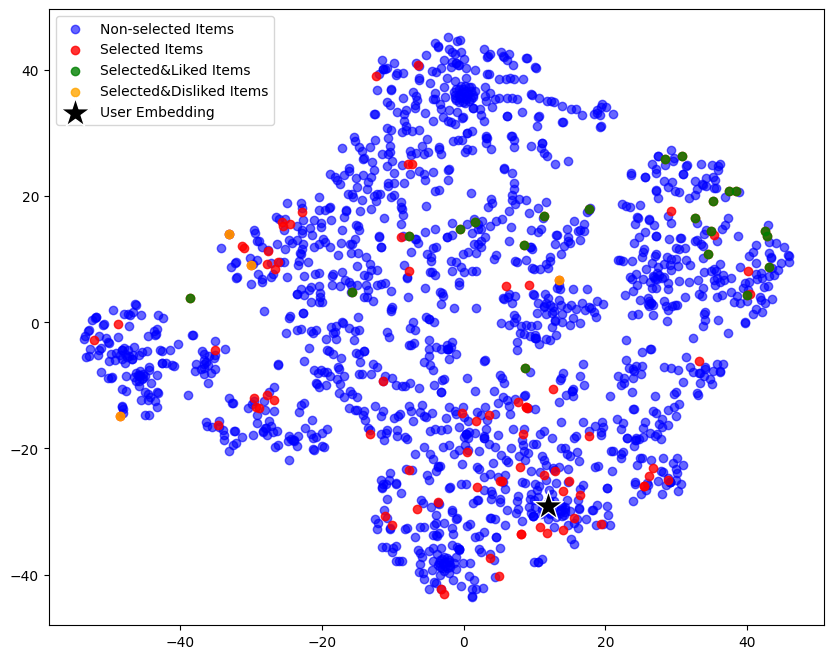

The percentage of liked items is:  21.0
The percentage of disliked items is:  4.0


In [48]:

# Initialize rewards, counts, and feedback log
#num_items = model.nb_works
rewards = np.zeros(num_items)
counts = np.zeros(num_items)
feedback_log = []  # To track feedback (True/False)

# Main recommendation loop
selected_movies = []
rounds = 200  # Number of recommendation rounds
correct_recommendations = 0

div = 0.5
rel = 0.5

for round_num in range(rounds):
    # Recommend a movie
    movie = recommend_movie_pareto_ucb(user_id, dissimilarity_matrix, rewards, counts, selected_movies, div, rel)
    title_value = titles.loc[titles['item'] == (movie + 1), 'title'].values[0]

    print(f"Round {round_num + 1}: Recommended Movie: {title_value}")

    v = 0
    # Get feedback based on the ratio of diversity to user relevance
    feedback, v = get_feedback(movie, user_id, dissimilarity_matrix, selected_movies, user_item_similarities, ridge_leverage_scores, metric="all")
    feedback_log.append(feedback)  # Log feedback for evaluation
    if feedback:
        correct_recommendations += 1  # Count correct recommendations (positive feedback)


    # Update rewards based on feedback
    update_rewards(movie, feedback, v, rewards, counts)

    # Add movie to selected list
    selected_movies.append(movie)

    print(f"Feedback for Movie: {feedback}")
    print(f"Updated Rewards: {rewards}")
    print(f"Updated Counts: {counts}\n")

k = 100
# Filter the last k movies selected
selected_movies = selected_movies[-k:]

# Evaluation: Accuracy of the recommendations
accuracy = correct_recommendations / rounds * 100
print(f"Accuracy of Recommendations: {accuracy:.2f}%")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Visualization
# Use t-SNE to reduce dimensions of the item embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
item_embeddings_2d = tsne.fit_transform(embeddings_I)

# Get the user embedding in 2D
user_embedding_2d = tsne.fit_transform(np.vstack([embeddings_I, embeddings_U[user_id]]))[-1]

# Plot the items
plt.figure(figsize=(10, 8))



# Plot non-selected items in blue
non_selected_items = [i for i in range(len(embeddings_I)) if i not in selected_movies]
plt.scatter(item_embeddings_2d[non_selected_items, 0], item_embeddings_2d[non_selected_items, 1], color='blue', label='Non-selected Items', alpha=0.6)

# Plot selected items in red
plt.scatter(item_embeddings_2d[selected_movies, 0], item_embeddings_2d[selected_movies, 1], color='red', label='Selected Items', alpha=0.8)

# Plot selected and liked items, at the same time, in green
liked_selected_items = (set(selected_movies).intersection(set(liked_items)))
Nliked_selected_items = (set(selected_movies).intersection(set(Nliked_items)))
# Convert to NumPy array
liked_selected_items = np.array(list(liked_selected_items))
Nliked_selected_items = np.array(list(Nliked_selected_items))

plt.scatter(item_embeddings_2d[liked_selected_items, 0], item_embeddings_2d[liked_selected_items, 1], color='green', label='Selected&Liked Items', alpha=0.8)
plt.scatter(item_embeddings_2d[Nliked_selected_items, 0], item_embeddings_2d[Nliked_selected_items, 1], color='orange', label='Selected&Disliked Items', alpha=0.8)

# Plot user embedding in bold black
plt.scatter(user_embedding_2d[0], user_embedding_2d[1], color='black', label='User Embedding', s=500, marker='*', edgecolors='white')


# Add labels and legend
#plt.title('t-SNE Visualization of User and Movie Embeddings')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')

# Show plot
plt.show()


percentage_liked = (len(liked_selected_items) / len(selected_movies)) * 100
percentage_Nliked = (len(Nliked_selected_items) / len(selected_movies)) * 100

print("The percentage of liked items is: ", percentage_liked)
print("The percentage of disliked items is: ", percentage_Nliked)

DPP

In [35]:

# Initialize rewards, counts, and feedback log
#num_items = model.nb_works
rewards = np.zeros(num_items)
counts = np.zeros(num_items)
feedback_log = []  # To track feedback (True/False)

# Main recommendation loop
selected_movies = []
rounds = 200  # Number of recommendation rounds
correct_recommendations = 0

div = 0.5
rel = 0.5

for round_num in range(rounds):
    # Recommend a movie
    movie = recommend_movie_pareto_ucb(user_id, dissimilarity_matrix, rewards, counts, selected_movies, div, rel)
    title_value = titles.loc[titles['item'] == (movie + 1), 'title'].values[0]

    print(f"Round {round_num + 1}: Recommended Movie: {title_value}")

    v = 0
    # Get feedback based on the ratio of diversity to user relevance
    feedback, v = get_feedback(movie, user_id, dissimilarity_matrix, selected_movies, user_item_similarities, ridge_leverage_scores, metric="dpp")
    feedback_log.append(feedback)  # Log feedback for evaluation
    if feedback:
        correct_recommendations += 1  # Count correct recommendations (positive feedback)


    # Update rewards based on feedback
    update_rewards(movie, feedback, v, rewards, counts)

    # Add movie to selected list
    selected_movies.append(movie)

    print(f"Feedback for Movie: {feedback}")
    print(f"Updated Rewards: {rewards}")
    print(f"Updated Counts: {counts}\n")

k = 100
# Filter the last k movies selected
selected_movies = selected_movies[-k:]

# Evaluation: Accuracy of the recommendations
accuracy = correct_recommendations / rounds * 100
print(f"Accuracy of Recommendations: {accuracy:.2f}%")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Visualization
# Use t-SNE to reduce dimensions of the item embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
item_embeddings_2d = tsne.fit_transform(embeddings_I)

# Get the user embedding in 2D
user_embedding_2d = tsne.fit_transform(np.vstack([embeddings_I, embeddings_U[user_id]]))[-1]

# Plot the items
plt.figure(figsize=(10, 8))



# Plot non-selected items in blue
non_selected_items = [i for i in range(len(embeddings_I)) if i not in selected_movies]
plt.scatter(item_embeddings_2d[non_selected_items, 0], item_embeddings_2d[non_selected_items, 1], color='blue', label='Non-selected Items', alpha=0.6)

# Plot selected items in red
plt.scatter(item_embeddings_2d[selected_movies, 0], item_embeddings_2d[selected_movies, 1], color='red', label='Selected Items', alpha=0.8)

# Plot selected and liked items, at the same time, in green
liked_selected_items = (set(selected_movies).intersection(set(liked_items)))
Nliked_selected_items = (set(selected_movies).intersection(set(Nliked_items)))
# Convert to NumPy array
liked_selected_items = np.array(list(liked_selected_items))
Nliked_selected_items = np.array(list(Nliked_selected_items))

plt.scatter(item_embeddings_2d[liked_selected_items, 0], item_embeddings_2d[liked_selected_items, 1], color='green', label='Selected&Liked Items', alpha=0.8)
plt.scatter(item_embeddings_2d[Nliked_selected_items, 0], item_embeddings_2d[Nliked_selected_items, 1], color='orange', label='Selected&Disliked Items', alpha=0.8)

# Plot user embedding in bold black
plt.scatter(user_embedding_2d[0], user_embedding_2d[1], color='black', label='User Embedding', s=500, marker='*', edgecolors='white')


# Add labels and legend
#plt.title('t-SNE Visualization of User and Movie Embeddings')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')

# Show plot
plt.show()


percentage_liked = (len(liked_selected_items) / len(selected_movies)) * 100
percentage_Nliked = (len(Nliked_selected_items) / len(selected_movies)) * 100

print("The percentage of liked items is: ", percentage_liked)
print("The percentage of disliked items is: ", percentage_Nliked)

Round 1: Recommended Movie: Wife, The (1995)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 2: Recommended Movie: Substance of Fire, The (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 3: Recommended Movie: Ill Gotten Gains (1997)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 4: Recommended Movie: Intimate Relations (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 5: Recommended Movie: Entertaining Angels: The Dorothy Day Story (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 6: Recommended Movie: Scream (1996)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 7: Recommended Movie: 

LinAlgError: Singular matrix

Ridge Leverage score

Round 1: Recommended Movie: Wife, The (1995)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 2: Recommended Movie: Star Wars (1977)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 3: Recommended Movie: Substance of Fire, The (1996)
Feedback for Movie: True
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 4: Recommended Movie: Ill Gotten Gains (1997)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 5: Recommended Movie: Jungle2Jungle (1997)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 6: Recommended Movie: Intimate Relations (1996)
Feedback for Movie: False
Updated Rewards: [0. 0. 0. ... 0. 0. 0.]
Updated Counts: [0. 0. 0. ... 0. 0. 0.]

Round 7: Recommended Movie: English Patient, The (1

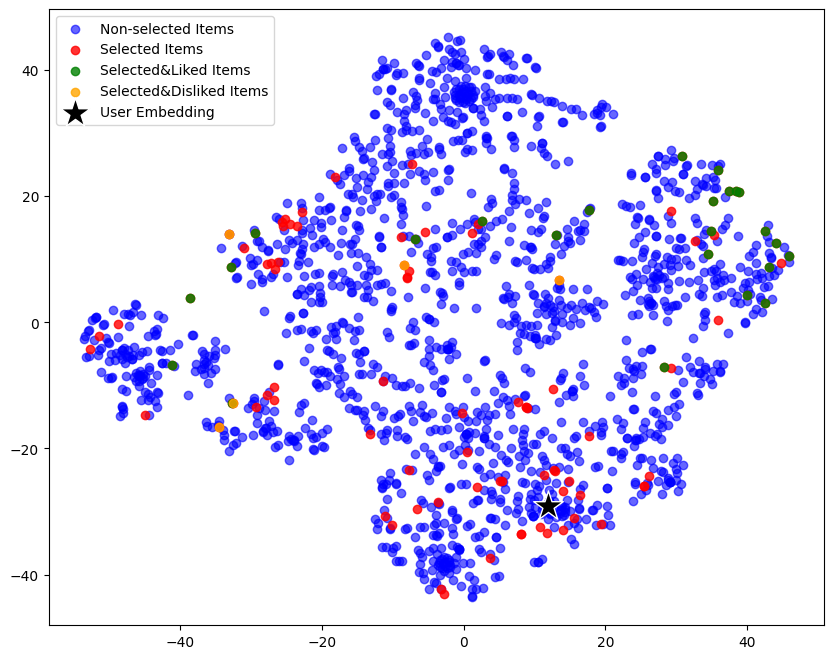

The percentage of liked items is:  24.0
The percentage of disliked items is:  5.0


In [24]:

# Initialize rewards, counts, and feedback log
#num_items = model.nb_works
rewards = np.zeros(num_items)
counts = np.zeros(num_items)
feedback_log = []  # To track feedback (True/False)

# Main recommendation loop
selected_movies = []
rounds = 200  # Number of recommendation rounds
correct_recommendations = 0

div = 0.5
rel = 0.5

for round_num in range(rounds):
    # Recommend a movie
    movie = recommend_movie_pareto_ucb(user_id, dissimilarity_matrix, rewards, counts, selected_movies, div, rel)
    title_value = titles.loc[titles['item'] == (movie + 1), 'title'].values[0]

    print(f"Round {round_num + 1}: Recommended Movie: {title_value}")

    v = 0
    # Get feedback based on the ratio of diversity to user relevance
    feedback, v = get_feedback(movie, user_id, dissimilarity_matrix, selected_movies, user_item_similarities, ridge_leverage_scores, metric="Rlev")
    feedback_log.append(feedback)  # Log feedback for evaluation
    if feedback:
        correct_recommendations += 1  # Count correct recommendations (positive feedback)


    # Update rewards based on feedback
    update_rewards(movie, feedback, v, rewards, counts)

    # Add movie to selected list
    selected_movies.append(movie)

    print(f"Feedback for Movie: {feedback}")
    print(f"Updated Rewards: {rewards}")
    print(f"Updated Counts: {counts}\n")

k = 100
# Filter the last k movies selected
selected_movies = selected_movies[-k:]

# Evaluation: Accuracy of the recommendations
accuracy = correct_recommendations / rounds * 100
print(f"Accuracy of Recommendations: {accuracy:.2f}%")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Visualization
# Use t-SNE to reduce dimensions of the item embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
item_embeddings_2d = tsne.fit_transform(embeddings_I)

# Get the user embedding in 2D
user_embedding_2d = tsne.fit_transform(np.vstack([embeddings_I, embeddings_U[user_id]]))[-1]

# Plot the items
plt.figure(figsize=(10, 8))



# Plot non-selected items in blue
non_selected_items = [i for i in range(len(embeddings_I)) if i not in selected_movies]
plt.scatter(item_embeddings_2d[non_selected_items, 0], item_embeddings_2d[non_selected_items, 1], color='blue', label='Non-selected Items', alpha=0.6)

# Plot selected items in red
plt.scatter(item_embeddings_2d[selected_movies, 0], item_embeddings_2d[selected_movies, 1], color='red', label='Selected Items', alpha=0.8)

# Plot selected and liked items, at the same time, in green
liked_selected_items = (set(selected_movies).intersection(set(liked_items)))
Nliked_selected_items = (set(selected_movies).intersection(set(Nliked_items)))
# Convert to NumPy array
liked_selected_items = np.array(list(liked_selected_items))
Nliked_selected_items = np.array(list(Nliked_selected_items))

plt.scatter(item_embeddings_2d[liked_selected_items, 0], item_embeddings_2d[liked_selected_items, 1], color='green', label='Selected&Liked Items', alpha=0.8)
plt.scatter(item_embeddings_2d[Nliked_selected_items, 0], item_embeddings_2d[Nliked_selected_items, 1], color='orange', label='Selected&Disliked Items', alpha=0.8)

# Plot user embedding in bold black
plt.scatter(user_embedding_2d[0], user_embedding_2d[1], color='black', label='User Embedding', s=500, marker='*', edgecolors='white')


# Add labels and legend
#plt.title('t-SNE Visualization of User and Movie Embeddings')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')

# Show plot
plt.show()


percentage_liked = (len(liked_selected_items) / len(selected_movies)) * 100
percentage_Nliked = (len(Nliked_selected_items) / len(selected_movies)) * 100

print("The percentage of liked items is: ", percentage_liked)
print("The percentage of disliked items is: ", percentage_Nliked)